### INDRA MORA
### 4212211007
### AAS MACHINE VISION/MK511
### Klasifikasi karakter tulisan tangan pada dataset EMNIST (Extended MNIST) menggunakan Convolutional Neural Network (CNN).

**Import Library**


In [31]:
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, f1_score
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random

**Proses pembacaan dataset Emnist**


In [32]:
data = pd.read_csv('/content/emnist-letters-train.csv',header=None)
test_data = pd.read_csv('/content/emnist-letters-test.csv',header=None)
print('Jumlah data train yang akan digunakan : ',data.shape)
print('Jumlah data test yang akan digunakan : ',test_data.shape)

Jumlah data train yang akan digunakan :  (88800, 785)
Jumlah data test yang akan digunakan :  (14800, 785)


**Proses pembagian dataset menjadi data training, validation, dan testing.**

In [33]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(data.values[:,1:], data.values[:,0], test_size=0.2, random_state = 42)
x_test = test_data.values[:,1:]
y_test = test_data.values[:,0]

In [34]:
print('Total of Training sets: ', x_train.shape[0])
print('Total of Validation sets: ', x_val.shape[0])
print('Total of Test sets: ', x_test.shape[0])
print('The range of values of x: (%d,%d)' %(np.min(x_train), np.max(x_train)))
print('Values of y: ', np.unique(y_train))

Total of Training sets:  71040
Total of Validation sets:  17760
Total of Test sets:  14800
The range of values of x: (0,255)
Values of y:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]


**Pra-pemrosesan data gambar dan visualisasi data agar bisa di proses ke CNN**

In [35]:
def resize_and_rotate(x):
  image = x.reshape(x.shape[0],28,28).astype('float32') #(x.shape[0],784) into (x.shape[0],28,28)
  image = np.expand_dims(image, axis = -1) #(x.shape[0],28,28) into (x.shape[0],28,28,1)
  image = np.fliplr(image)
  image = np.rot90(image, axes=(2,1))
  return image

In [36]:
x_train = resize_and_rotate(x_train)
x_val = resize_and_rotate(x_val)
x_test = resize_and_rotate(x_test)

In [37]:
def read_image_rot(data,label,name):
  fig, axes = plt.subplots(2,5, figsize=(10,5))
  for i, ax in enumerate(axes.flat):
    ax.imshow(data[i],cmap='gray')
    ax.set_title("%c,%d" %(chr(96+label[i]),label[i]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
  plt.suptitle(name)

**Menampilkan Gambar Acak dari Data Training**


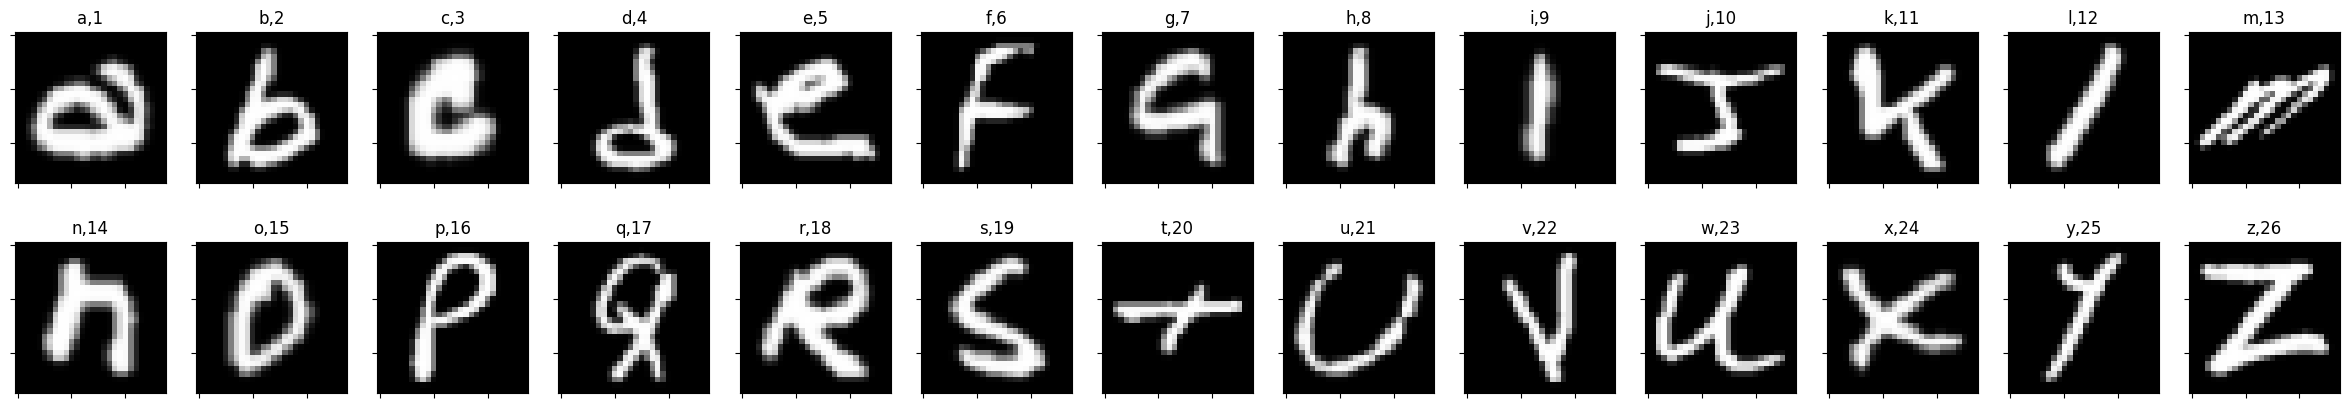

In [38]:
rand = []
for i in np.unique(y_train):
  ind = np.where(y_train == i)[0]
  rand.append(random.choice(ind))

fig, axes = plt.subplots(2,13, figsize = (30,5))
for i, ax in enumerate(axes.flat):
  ax.imshow(x_train[rand[i]], cmap='gray')
  ax.set_title("%c,%d" %(chr(96+y_train[rand[i]]),y_train[rand[i]]))
  ax.set_xticklabels([])
  ax.set_yticklabels([])

**Mengecek data validation dan test set secara visual**

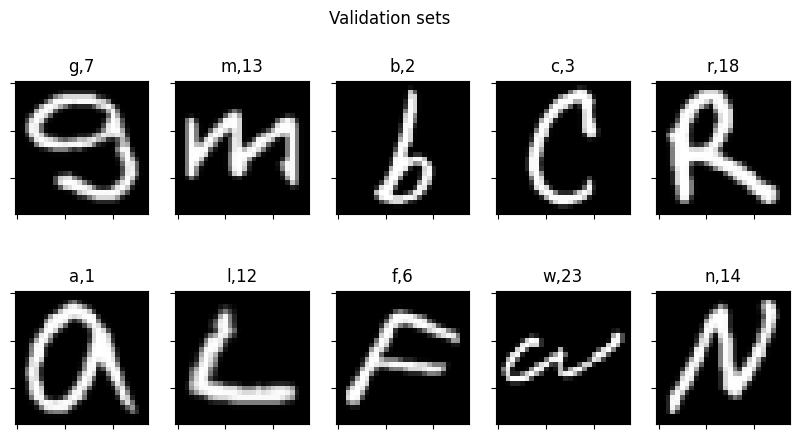

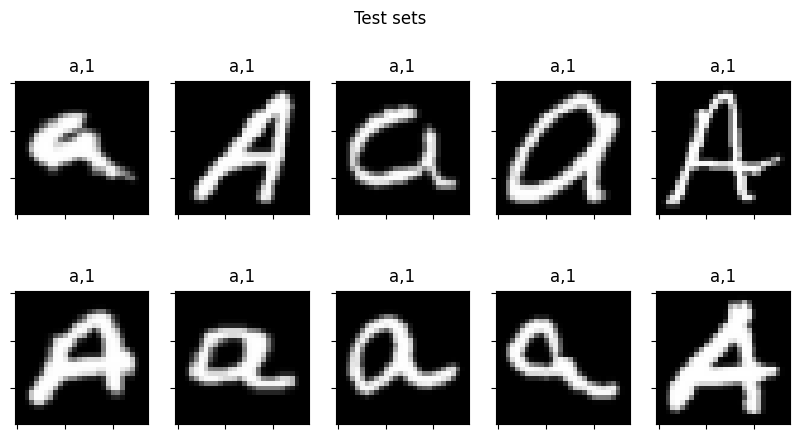

In [39]:
read_image_rot(x_val[:10], y_val[:10],'Validation sets')
read_image_rot(x_test[:10], y_test[:10],'Test sets')

In [40]:
number_of_classes = len(np.unique(y_train))+1
y_train = tf.keras.utils.to_categorical(y_train, number_of_classes)
y_val = tf.keras.utils.to_categorical(y_val, number_of_classes)
y_test = tf.keras.utils.to_categorical(y_test, number_of_classes)

In [41]:
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test/ 255.0

**Proses Klasifikasi Gambar**

In [42]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28,28,1)),
    tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu'),  # Reduce filters
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'),  # Reduce filters
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),  # Reduce units
    tf.keras.layers.Dense(number_of_classes, activation='softmax')
])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3872)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         495,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 27)                  │           3,483 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 504,027 (1.92 MB)

 Trainable params: 504,027 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

None


**Proses Pelatihal mode l menggunakan Tensorflow**

In [43]:
model.compile(loss = 'categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, verbose=1)

Epoch 1/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 84s 36ms/step - accuracy: 0.7358 - loss: 0.8731 - val_accuracy: 0.9026 - val_loss: 0.3103
Epoch 2/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 97s 42ms/step - accuracy: 0.9102 - loss: 0.2678 - val_accuracy: 0.9155 - val_loss: 0.2546
Epoch 3/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 120s 32ms/step - accuracy: 0.9316 - loss: 0.1970 - val_accuracy: 0.9241 - val_loss: 0.2394
Epoch 4/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 84s 38ms/step - accuracy: 0.9442 - loss: 0.1571 - val_accuracy: 0.9255 - val_loss: 0.2391
Epoch 5/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 160s 46ms/step - accuracy: 0.9539 - loss: 0.1257 - val_accuracy: 0.9236 - val_loss: 0.2514
Epoch 6/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 113s 33ms/step - accuracy: 0.9598 - loss: 0.1033 - val_accuracy: 0.9221 - val_loss: 0.2624
Epoch 7/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 71s 32ms/step - accuracy: 0.9647 - loss: 0.0876 - val_accuracy: 0.9231 - val_loss: 0.2921
Epoch 8/10
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 79s 31ms/step - accuracy: 0.969

**Proses menampilkan nilai Accuracy, Precision, Recall dan F1 Score**

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

predict_train = model.predict(x_train)
predict_test = model.predict(x_test)

y_train_pred = np.argmax(predict_train, axis=1)
y_test_pred = np.argmax(predict_test, axis=1)
y_train_true = np.argmax(y_train, axis=1)
y_test_true = np.argmax(y_test, axis=1)

train_accuracy = accuracy_score(y_train_true, y_train_pred)
test_accuracy = accuracy_score(y_test_true, y_test_pred)

train_precision = precision_score(y_train_true, y_train_pred, average='micro')
test_precision = precision_score(y_test_true, y_test_pred, average='micro')

train_recall = recall_score(y_train_true, y_train_pred, average='micro')
test_recall = recall_score(y_test_true, y_test_pred, average='micro')

train_f1 = f1_score(y_train_true, y_train_pred, average='micro')
test_f1 = f1_score(y_test_true, y_test_pred, average='micro')

# Print all metrics
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

2220/2220 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step
463/463 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Train Accuracy: 0.9773
Test Accuracy: 0.9063
Train Precision: 0.9773
Test Precision: 0.9063
Train Recall: 0.9773
Test Recall: 0.9063
Train F1-Score: 0.9773
Test F1-Score: 0.9063


**Proses untuk membuat dan menampilkan Confusion Matrix**

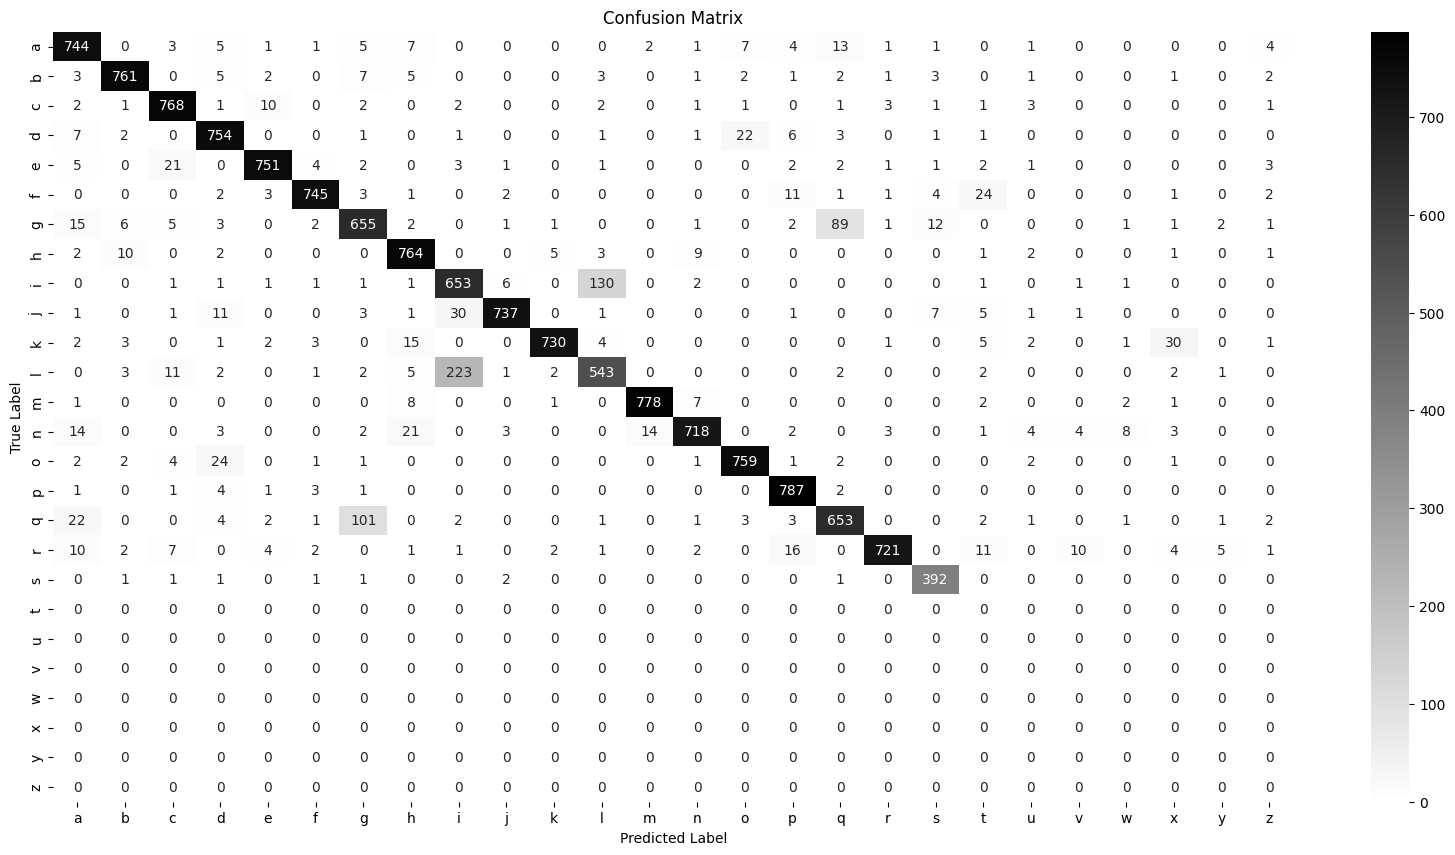

In [45]:
conf_matrix = confusion_matrix(y_test_true, y_test_pred)
letter = [chr(96 + i) for i in range(1, 27)]
plt.figure(figsize=(20, 10))
sns.heatmap(conf_matrix, annot=True, cmap='binary', fmt='.0f', xticklabels=letter, yticklabels=letter)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()